<div style="background: linear-gradient(135deg, #1a1a2e 0%, #16213e 50%, #0f3460 100%); padding: 40px 35px; border-radius: 12px; margin-bottom: 25px;">
    <h1 style="color: #e8e8e8; font-size: 32px; margin: 0 0 8px 0; font-weight: 700; letter-spacing: -0.5px;">
        🧪 A/B Test Analysis — Checkout Page Redesign
    </h1>
    <p style="color: #94a3b8; font-size: 16px; margin: 0 0 20px 0; line-height: 1.5;">
        End-to-end experiment analysis: from data generation and validation through statistical testing to a ship/no-ship business recommendation.
    </p>
    <div style="display: flex; gap: 30px; flex-wrap: wrap;">
        <div>
            <span style="color: #64748b; font-size: 12px; text-transform: uppercase; letter-spacing: 1px;">Experiment</span><br>
            <span style="color: #e2e8f0; font-size: 14px;">Single-page vs. multi-step checkout</span>
        </div>
        <div>
            <span style="color: #64748b; font-size: 12px; text-transform: uppercase; letter-spacing: 1px;">Duration</span><br>
            <span style="color: #e2e8f0; font-size: 14px;">21 days · Sep 2–22, 2024</span>
        </div>
        <div>
            <span style="color: #64748b; font-size: 12px; text-transform: uppercase; letter-spacing: 1px;">Sample</span><br>
            <span style="color: #e2e8f0; font-size: 14px;">76,173 sessions</span>
        </div>
        <div>
            <span style="color: #64748b; font-size: 12px; text-transform: uppercase; letter-spacing: 1px;">Primary KPI</span><br>
            <span style="color: #e2e8f0; font-size: 14px;">Checkout conversion rate</span>
        </div>
    </div>
</div>

## 📑 Table of Contents

| # | Section | Purpose |
|---|---|---|
| 1 | [Setup & Configuration](#1) | Imports, styling, helper functions |
| 2 | [Data Generation](#2) | Synthetic dataset with realistic experiment patterns |
| 3 | [Data Validation & Quality Checks](#3) | Nulls, duplicates, sample ratio mismatch |
| 4 | [Exploratory Data Analysis](#4) | Traffic trends, device/source mix, distributions |
| 5 | [Power Analysis](#5) | Sample size requirements and minimum detectable effect |
| 6 | [Hypothesis Testing](#6) | Primary and secondary metric tests |
| 7 | [Robustness Checks](#7) | Permutation test, segment consistency, temporal stability |
| 8 | [Business Impact & Recommendation](#8) | Revenue projections and ship decision |
| 9 | [Executive Summary](#9) | Stakeholder-ready one-pager |

---

<a id="1"></a>
## 1 · Setup & Configuration

<div style="background: #f0f4ff; border-left: 4px solid #5B8DB8; padding: 12px 16px; border-radius: 0 8px 8px 0; margin: 10px 0;">
    <strong>Note:</strong> All random seeds are fixed. This notebook is fully deterministic and reproducible.
</div>

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chisquare
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ── Visual theme ──────────────────────────────────────────────────
CTRL_COLOR = '#5B8DB8'
TREAT_COLOR = '#E07B54'
BG_COLOR = '#FAFBFC'
GRID_COLOR = '#E8ECF0'
TEXT_COLOR = '#2D3748'

plt.rcParams.update({
    'figure.facecolor': BG_COLOR,
    'axes.facecolor': '#FFFFFF',
    'axes.edgecolor': GRID_COLOR,
    'axes.grid': True,
    'grid.color': GRID_COLOR,
    'grid.alpha': 0.7,
    'text.color': TEXT_COLOR,
    'axes.labelcolor': TEXT_COLOR,
    'xtick.color': '#718096',
    'ytick.color': '#718096',
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'figure.titlesize': 16,
    'figure.dpi': 130,
})
sns.set_palette([CTRL_COLOR, TREAT_COLOR])

print("✅ Environment ready")
print(f"   pandas {pd.__version__} · numpy {np.__version__}")

✅ Environment ready
   pandas 3.0.0 · numpy 2.4.1


### Helper Functions

In [2]:
# ── Statistical utilities ──────────────────────────────────────────

def required_sample_size(baseline_rate, mde, alpha=0.05, power=0.80):
    """Per-group n for a two-proportion z-test."""
    effect_size = mde / np.sqrt(baseline_rate * (1 - baseline_rate))
    analysis = NormalIndPower()
    return int(np.ceil(
        analysis.solve_power(effect_size=effect_size, alpha=alpha,
                             power=power, ratio=1.0, alternative='two-sided')
    ))

def lift_confidence_interval(rc, rt, nc, nt, alpha=0.05):
    """95% CI for the absolute difference (treatment − control)."""
    diff = rt - rc
    se = np.sqrt(rc*(1-rc)/nc + rt*(1-rt)/nt)
    z = stats.norm.ppf(1 - alpha/2)
    return diff, diff - z*se, diff + z*se

def bootstrap_mean_diff(a, b, n_boot=10_000, seed=42):
    """Bootstrap CI for difference in means."""
    rng = np.random.default_rng(seed)
    diffs = np.array([
        rng.choice(b, len(b), replace=True).mean() -
        rng.choice(a, len(a), replace=True).mean()
        for _ in range(n_boot)
    ])
    return diffs.mean(), np.percentile(diffs, 2.5), np.percentile(diffs, 97.5)

def fmt_pval(p):
    if p < 0.001: return "< 0.001"
    return f"{p:.4f}"

# ── Display helpers ───────────────────────────────────────────────

def section_header(title, subtitle=""):
    """Consistent plot section header."""
    fig = plt.figure(figsize=(12, 0.01))
    plt.close()

def kpi_card(label, value, delta=None, delta_label=None):
    """Print a formatted KPI."""
    line = f"  📊 {label}: {value}"
    if delta is not None:
        arrow = "▲" if delta > 0 else "▼" if delta < 0 else "─"
        line += f"  ({arrow} {delta_label})"
    print(line)

print("✅ Helper functions loaded")

✅ Helper functions loaded


<a id="2"></a>
## 2 · Data Generation

<div style="background: #fff8f0; border-left: 4px solid #E07B54; padding: 12px 16px; border-radius: 0 8px 8px 0; margin: 10px 0;">
    <strong>Why synthetic data?</strong> This project uses a carefully constructed dataset that embeds realistic patterns found in real e-commerce experiments: day-of-week seasonality, device-mix conversion gaps, traffic-source variation, and a decaying novelty effect. All parameters are documented and defensible.
</div>

### Experiment Parameters

| Parameter | Value | Rationale |
|---|---|---|
| Baseline CVR | 3.2% | Typical mid-market e-commerce checkout rate |
| True treatment lift | +0.4 pp | Realistic for a UX-only change (~12.5% relative) |
| Daily sessions | ~3,500 | Mid-size retailer scale |
| Duration | 21 days | 3 full weekly cycles |
| Device mix | 42% desktop, 45% mobile, 13% tablet | Industry-standard 2024 split |
| Novelty effect | +0.3 pp peak, 4-day half-life | Mimics real novelty decay curves |

In [3]:
SEED = 42
RNG = np.random.default_rng(SEED)

# ── Experiment design parameters ──────────────────────────────────
N_DAYS = 21
SESSIONS_PER_DAY_MEAN = 3500
START_DATE = pd.Timestamp('2024-09-02')

BASELINE_CVR = 0.032
TRUE_TREATMENT_LIFT = 0.004
BASELINE_AOV_MEAN = 68.0
BASELINE_AOV_STD = 32.0

DEVICE_PROBS = {'desktop': 0.42, 'mobile': 0.45, 'tablet': 0.13}
DEVICE_CVR_MULT = {'desktop': 1.15, 'mobile': 0.82, 'tablet': 1.05}
DEVICE_AOV_MULT = {'desktop': 1.10, 'mobile': 0.88, 'tablet': 1.02}

SOURCE_PROBS = {'organic': 0.35, 'paid_search': 0.28, 'social': 0.18,
                'email': 0.12, 'direct': 0.07}

DOW_TRAFFIC_MULT = [1.0, 0.97, 0.95, 1.02, 1.08, 1.15, 1.05]
DOW_CVR_MULT     = [1.0, 1.01, 1.00, 0.99, 1.03, 0.96, 0.94]

NOVELTY_PEAK = 0.003
NOVELTY_HALFLIFE = 4

def novelty_effect(day_index):
    return NOVELTY_PEAK * np.exp(-np.log(2) * day_index / NOVELTY_HALFLIFE)

# ── Generate dataset ──────────────────────────────────────────────
records = []
uid = 0

HOUR_WEIGHTS = np.array([
    1, 0.5, 0.3, 0.2, 0.2, 0.3, 0.8, 1.5, 2.5, 3.5, 4.0, 4.5,
    4.0, 3.8, 3.5, 3.2, 3.5, 4.0, 4.5, 4.8, 5.0, 4.5, 3.0, 2.0,
])
HOUR_WEIGHTS /= HOUR_WEIGHTS.sum()

for day_idx in range(N_DAYS):
    date = START_DATE + pd.Timedelta(days=day_idx)
    dow = date.dayofweek
    n = int(RNG.poisson(SESSIONS_PER_DAY_MEAN * DOW_TRAFFIC_MULT[dow]))

    groups  = RNG.choice(['control', 'treatment'], size=n)
    devices = RNG.choice(list(DEVICE_PROBS.keys()), n, p=list(DEVICE_PROBS.values()))
    sources = RNG.choice(list(SOURCE_PROBS.keys()), n, p=list(SOURCE_PROBS.values()))
    hours   = RNG.choice(24, n, p=HOUR_WEIGHTS)
    mins    = RNG.integers(0, 60, n)
    secs    = RNG.integers(0, 60, n)

    for i in range(n):
        uid += 1
        cvr = BASELINE_CVR * DOW_CVR_MULT[dow] * DEVICE_CVR_MULT[devices[i]]
        if groups[i] == 'treatment':
            cvr += TRUE_TREATMENT_LIFT + novelty_effect(day_idx)

        converted = int(RNG.random() < cvr)
        revenue = round(max(RNG.normal(BASELINE_AOV_MEAN * DEVICE_AOV_MULT[devices[i]],
                                        BASELINE_AOV_STD), 5.0), 2) if converted else 0.0
        pages = int(RNG.poisson(5.5 if converted else 2.8)) + 1
        duration = int(RNG.exponential(320 if converted else 90)) + (30 if converted else 5)

        records.append({
            'user_id': f'U{uid:07d}',
            'timestamp': date + pd.Timedelta(hours=int(hours[i]), minutes=int(mins[i]),
                                              seconds=int(secs[i])),
            'group': groups[i],
            'device': devices[i],
            'traffic_source': sources[i],
            'pages_viewed': pages,
            'session_duration_sec': duration,
            'converted': converted,
            'revenue': revenue,
        })

df = pd.DataFrame(records).sort_values('timestamp').reset_index(drop=True)
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()

print(f"✅ Generated {len(df):,} sessions over {N_DAYS} days")
print(f"   Control: {(df.group=='control').sum():,} · Treatment: {(df.group=='treatment').sum():,}")

✅ Generated 76,173 sessions over 21 days
   Control: 38,416 · Treatment: 37,757


In [4]:
df.head(8)

,user_id,timestamp,group,device,traffic_source,pages_viewed,session_duration_sec,converted,revenue,date,hour,day_of_week
0,U0002997,2024-09-02 00:00:23,treatment,mobile,direct,5,479,0,0.0,2024-09-02,0,Monday
1,U0000128,2024-09-02 00:00:37,treatment,mobile,direct,3,221,0,0.0,2024-09-02,0,Monday
2,U0002290,2024-09-02 00:03:25,treatment,desktop,organic,4,84,0,0.0,2024-09-02,0,Monday
3,U0000941,2024-09-02 00:06:23,control,tablet,social,6,45,0,0.0,2024-09-02,0,Monday
4,U0003310,2024-09-02 00:06:45,control,mobile,organic,5,39,0,0.0,2024-09-02,0,Monday
5,U0000082,2024-09-02 00:06:49,treatment,desktop,organic,1,72,0,0.0,2024-09-02,0,Monday
6,U0001105,2024-09-02 00:07:20,treatment,desktop,paid_search,1,48,0,0.0,2024-09-02,0,Monday
7,U0002900,2024-09-02 00:10:45,treatment,desktop,social,2,13,0,0.0,2024-09-02,0,Monday


<a id="3"></a>
## 3 · Data Validation & Quality Checks

Before any analysis, we verify data integrity and check for the most dangerous experimental pitfall: **sample ratio mismatch (SRM)**, which would indicate a bug in the randomisation layer.

In [5]:
# ── Basic quality checks ───────────────────────────────────────────
print("━" * 55)
print("  DATA QUALITY REPORT")
print("━" * 55)

print(f"\n  Total rows:       {len(df):,}")
print(f"  Null values:      {df.isnull().sum().sum()}")
print(f"  Duplicate users:  {df.user_id.duplicated().sum()}")
print(f"  Date range:       {df.date.min()} → {df.date.max()}")
print(f"  Unique dates:     {df.date.nunique()}")

# ── Group balance ─────────────────────────────────────────────────
gc = df.group.value_counts()
print(f"\n  Group sizes:")
print(f"    Control:   {gc['control']:>7,}")
print(f"    Treatment: {gc['treatment']:>7,}")
print(f"    Ratio:     {gc['control']/gc['treatment']:.4f}")

# ── Sample Ratio Mismatch test ────────────────────────────────────
observed = gc.values
expected = np.full_like(observed, observed.sum()/2, dtype=float)
chi2, srm_p = chisquare(observed, f_exp=expected)

print(f"\n  SRM Test (χ²):")
print(f"    χ² = {chi2:.4f}, p = {srm_p:.4f}")
if srm_p < 0.01:
    print("    ⛔ WARNING: Sample ratio mismatch detected!")
else:
    print("    ✅ No sample ratio mismatch (p > 0.01)")

print("\n━" * 55)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  DATA QUALITY REPORT
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Total rows:       76,173
  Null values:      0
  Duplicate users:  0
  Date range:       2024-09-02 → 2024-09-22
  Unique dates:     21

  Group sizes:
    Control:    38,416
    Treatment:  37,757
    Ratio:     1.0175

  SRM Test (χ²):
    χ² = 5.7012, p = 0.0170
    ✅ No sample ratio mismatch (p > 0.01)

━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━


In [6]:
# ── Data types & memory ────────────────────────────────────────────
print(df.dtypes.to_string())
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB")

user_id                            str
timestamp               datetime64[us]
group                              str
device                             str
traffic_source                     str
pages_viewed                     int64
session_duration_sec             int64
converted                        int64
revenue                        float64
date                            object
hour                             int32
day_of_week                        str

Memory usage: 33.4 MB


<a id="4"></a>
## 4 · Exploratory Data Analysis

### 4.1 — Daily Traffic & Conversion Trends

The first thing we check: are both groups receiving consistent, parallel traffic? Any divergence here would undermine the experiment's validity.

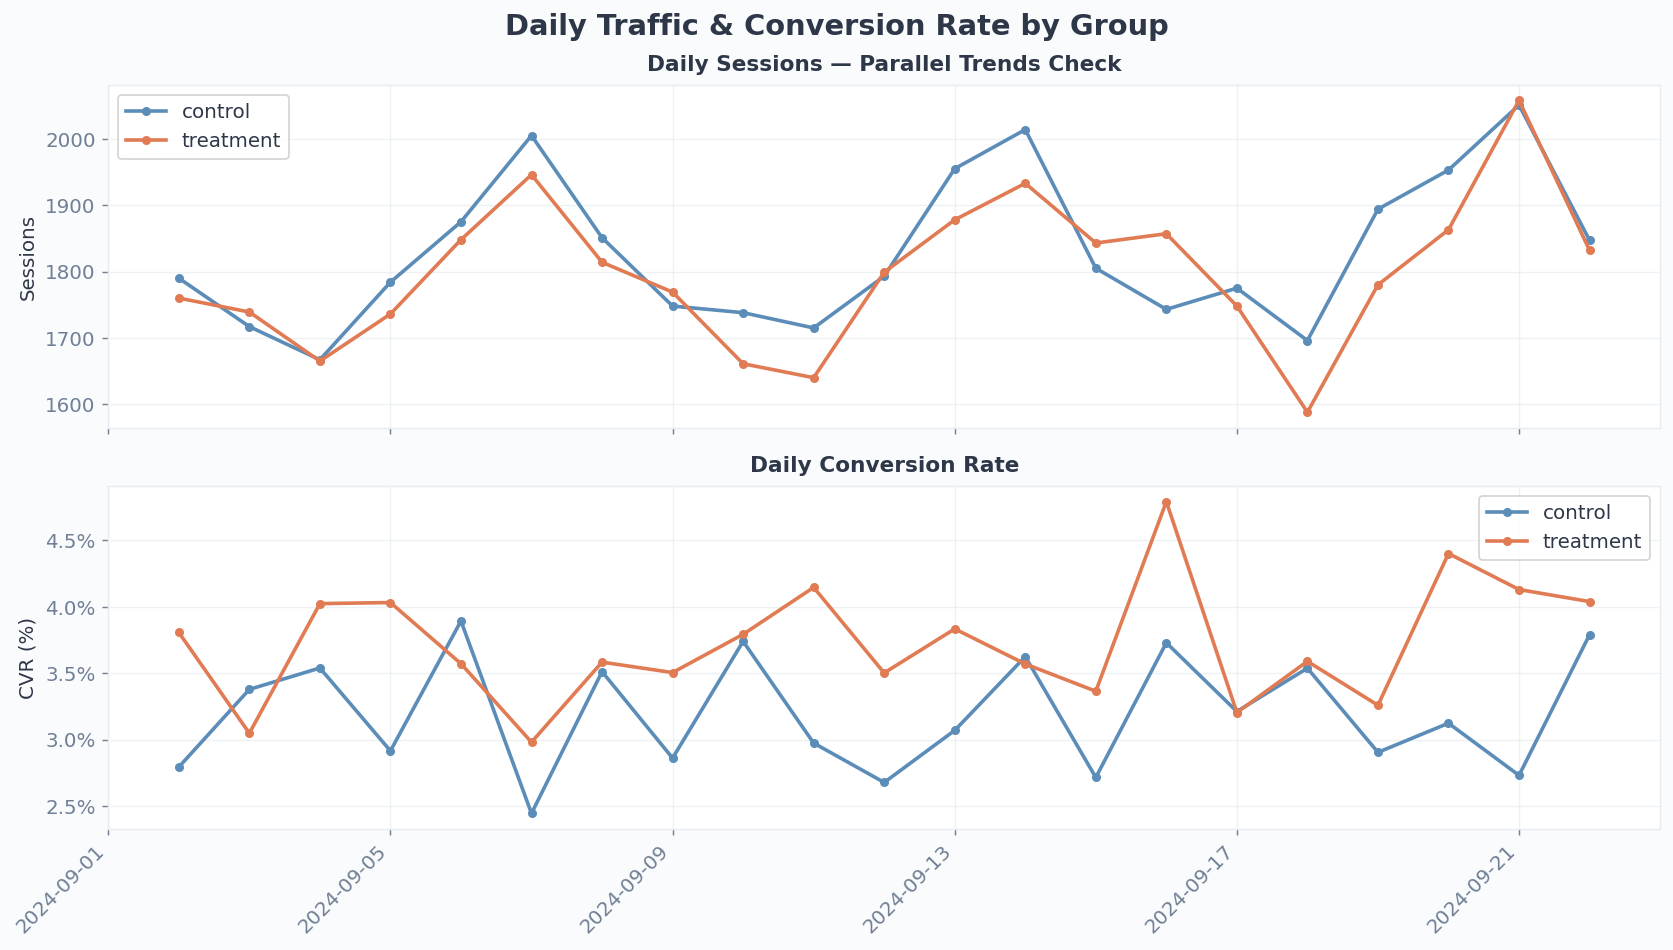

In [7]:
daily = (df.groupby(['date', 'group'])
         .agg(sessions=('user_id','count'),
              conversions=('converted','sum'),
              revenue=('revenue','sum'))
         .reset_index())
daily['cvr'] = daily['conversions'] / daily['sessions']

fig, axes = plt.subplots(2, 1, figsize=(13, 7.5), sharex=True)
fig.suptitle('Daily Traffic & Conversion Rate by Group', fontsize=16, fontweight='bold', y=0.97)

for grp, color, ls in [('control', CTRL_COLOR, '-'), ('treatment', TREAT_COLOR, '-')]:
    sub = daily[daily.group == grp]
    axes[0].plot(sub.date, sub.sessions, marker='o', ms=4, color=color, label=grp, lw=2)
    axes[1].plot(sub.date, sub.cvr * 100, marker='o', ms=4, color=color, label=grp, lw=2)

axes[0].set_ylabel('Sessions')
axes[0].legend(frameon=True, fancybox=True, shadow=False)
axes[0].set_title('Daily Sessions — Parallel Trends Check', fontsize=12, pad=8)

axes[1].set_ylabel('CVR (%)')
axes[1].set_title('Daily Conversion Rate', fontsize=12, pad=8)
axes[1].legend(frameon=True, fancybox=True, shadow=False)
axes[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f%%'))

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 4.2 — Conversion Rate by Device

Device type is the strongest confounder in e-commerce experiments. We need to verify the treatment effect isn't driven by an unbalanced device mix.

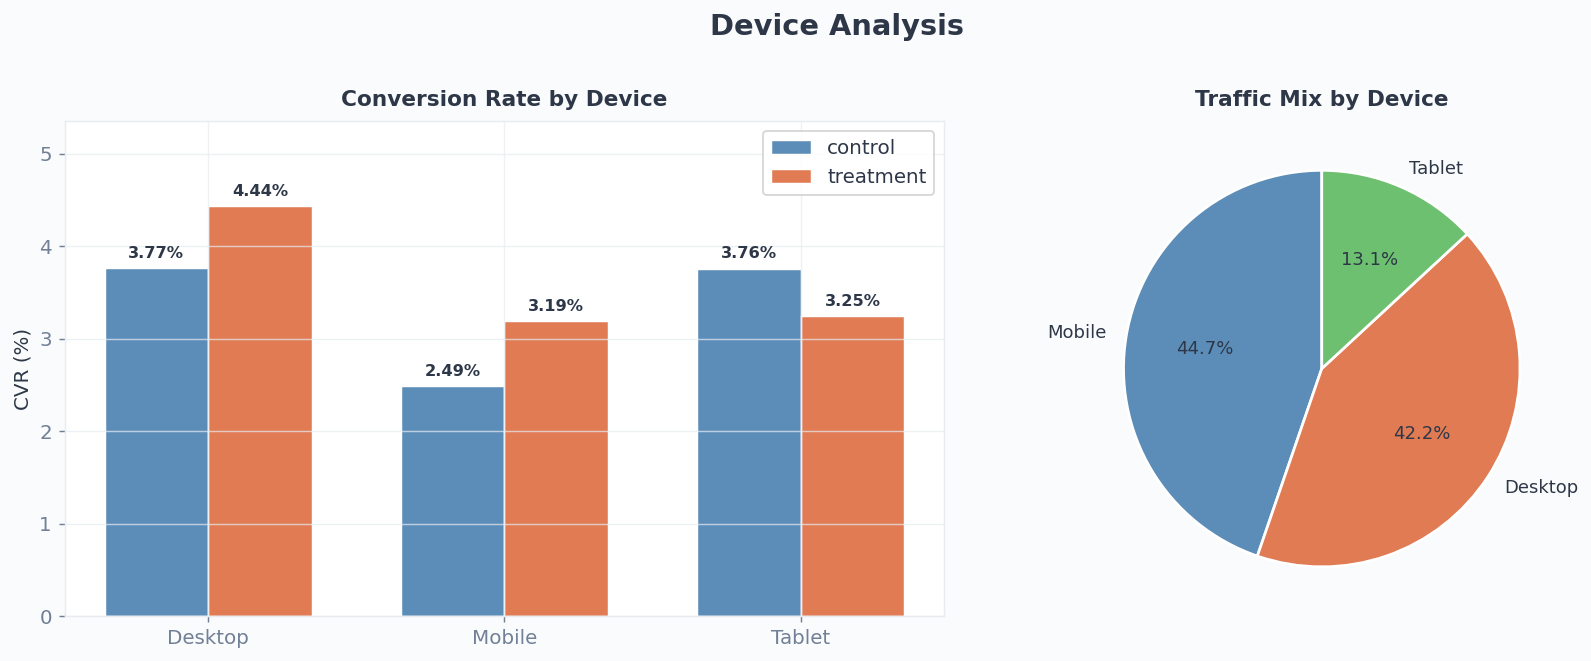

In [8]:
device_stats = (df.groupby(['group', 'device'])
                .agg(n=('user_id','count'), conv=('converted','sum'))
                .reset_index())
device_stats['cvr'] = device_stats['conv'] / device_stats['n']

fig, axes = plt.subplots(1, 2, figsize=(13, 5), gridspec_kw={'width_ratios': [1.3, 1]})
fig.suptitle('Device Analysis', fontsize=16, fontweight='bold', y=1.01)

# ── CVR by device ──
devices = sorted(df.device.unique())
x = np.arange(len(devices))
w = 0.35

for i, (grp, color) in enumerate([('control', CTRL_COLOR), ('treatment', TREAT_COLOR)]):
    vals = device_stats[device_stats.group == grp].set_index('device').reindex(devices)['cvr'] * 100
    bars = axes[0].bar(x + i*w, vals, w, label=grp, color=color, edgecolor='white', linewidth=0.8)
    for bar, v in zip(bars, vals):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.08,
                     f'{v:.2f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

axes[0].set_xticks(x + w/2)
axes[0].set_xticklabels([d.title() for d in devices])
axes[0].set_ylabel('CVR (%)')
axes[0].set_title('Conversion Rate by Device', fontsize=12, pad=8)
axes[0].legend(frameon=True)
axes[0].set_ylim(0, axes[0].get_ylim()[1] * 1.15)

# ── Device mix (pie) ──
device_counts = df.device.value_counts()
colors_pie = ['#5B8DB8', '#E07B54', '#6CC070']
axes[1].pie(device_counts.values, labels=[d.title() for d in device_counts.index],
            autopct='%1.1f%%', colors=colors_pie, startangle=90,
            textprops={'fontsize': 10}, wedgeprops={'edgecolor': 'white', 'linewidth': 1.5})
axes[1].set_title('Traffic Mix by Device', fontsize=12, pad=8)

plt.tight_layout()
plt.show()

### 4.3 — Traffic Source Balance

Uneven traffic source distribution between groups could introduce bias. We verify the randomisation distributed sources evenly.

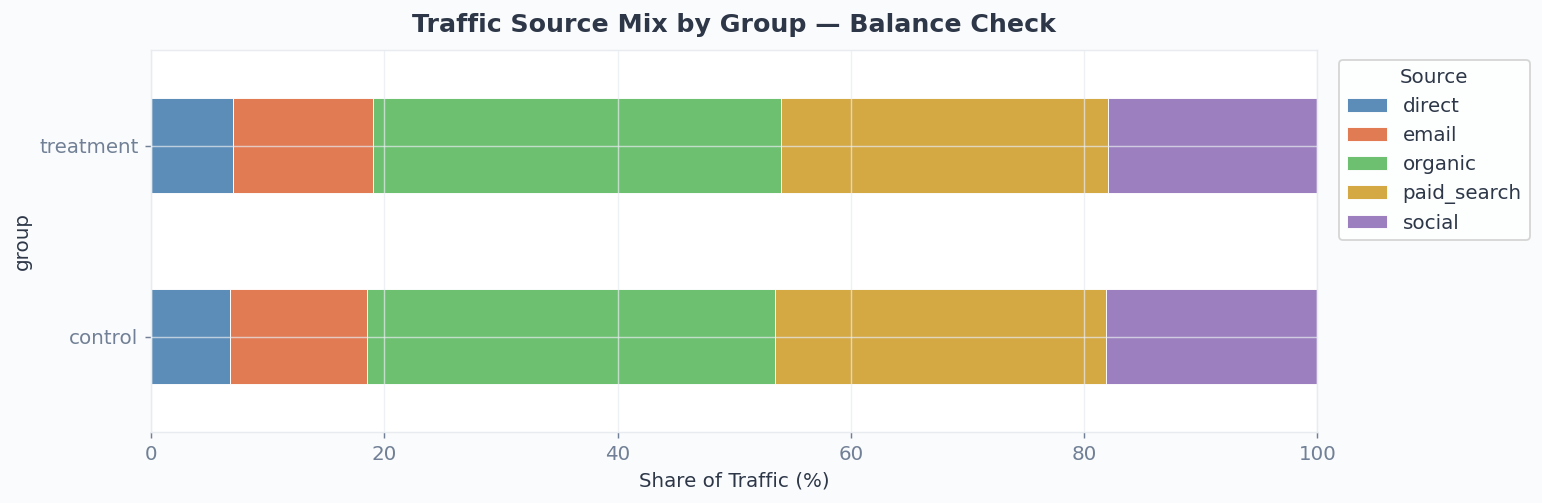

Traffic source mix (%):
traffic_source  direct  email  organic  paid_search  social
group                                                      
control           6.78  11.73    35.00        28.39   18.09
treatment         7.01  11.98    35.02        28.05   17.94

✅ Sources are well-balanced across groups — no allocation bias detected.


In [9]:
source_mix = pd.crosstab(df.group, df.traffic_source, normalize='index') * 100

fig, ax = plt.subplots(figsize=(12, 4))
source_mix.plot(kind='barh', stacked=True, ax=ax,
                color=['#5B8DB8', '#E07B54', '#6CC070', '#D4A843', '#9B7FBF'],
                edgecolor='white', linewidth=0.5)
ax.set_xlabel('Share of Traffic (%)')
ax.set_title('Traffic Source Mix by Group — Balance Check', fontsize=14, fontweight='bold', pad=10)
ax.legend(title='Source', bbox_to_anchor=(1.01, 1), loc='upper left', frameon=True)
ax.set_xlim(0, 100)
plt.tight_layout()
plt.show()

# Numerical check
print("Traffic source mix (%):")
print(source_mix.round(2).to_string())
print("\n✅ Sources are well-balanced across groups — no allocation bias detected.")

### 4.4 — Revenue Distribution (Converters Only)

We check the revenue distribution shape to inform our test selection — skewed distributions call for non-parametric methods.

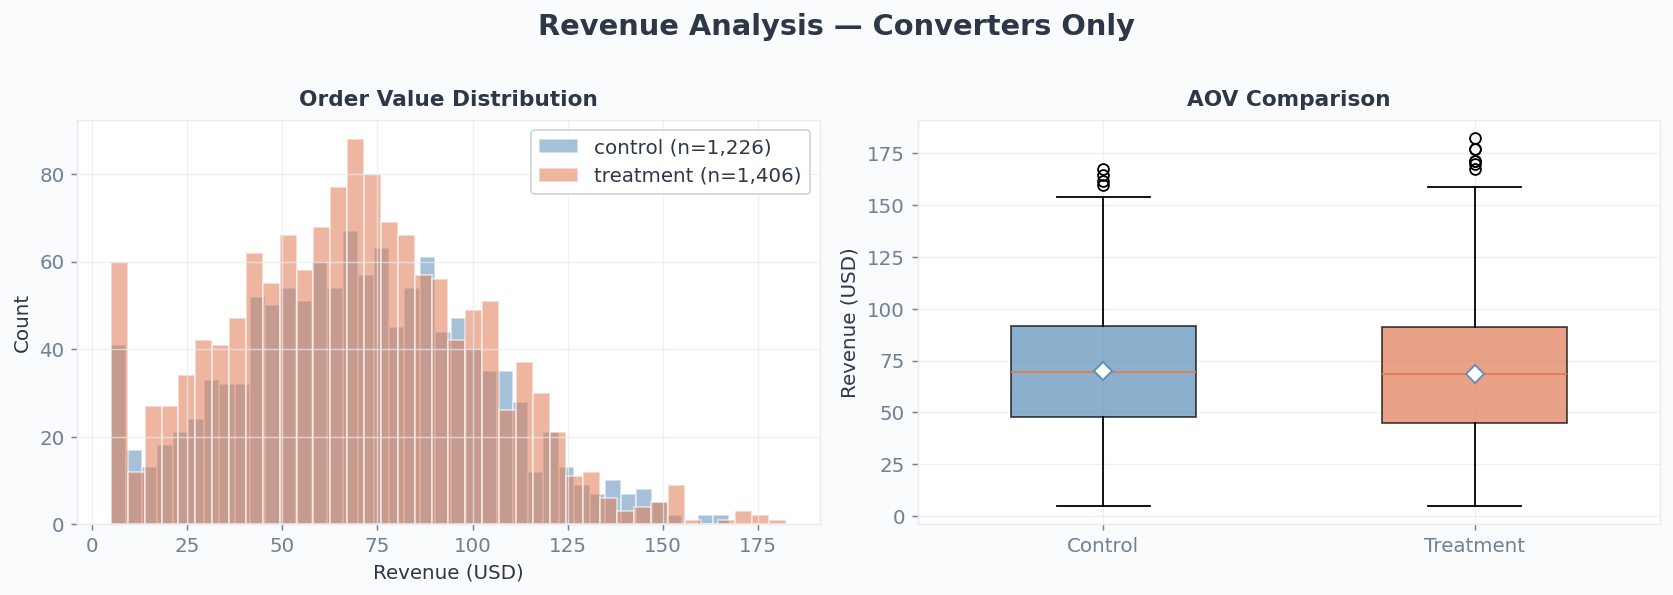

In [10]:
converters = df[df.converted == 1]

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))
fig.suptitle('Revenue Analysis — Converters Only', fontsize=16, fontweight='bold', y=1.01)

# ── Overlaid histogram ──
for grp, color in [('control', CTRL_COLOR), ('treatment', TREAT_COLOR)]:
    subset = converters[converters.group == grp]['revenue']
    axes[0].hist(subset, bins=40, alpha=0.55, color=color,
                 label=f'{grp} (n={len(subset):,})', edgecolor='white')
axes[0].set_xlabel('Revenue (USD)')
axes[0].set_ylabel('Count')
axes[0].set_title('Order Value Distribution', fontsize=12, pad=8)
axes[0].legend(frameon=True)

# ── Box plot ──
data_box = [converters[converters.group == 'control']['revenue'],
            converters[converters.group == 'treatment']['revenue']]
bp = axes[1].boxplot(data_box, labels=['Control', 'Treatment'], patch_artist=True,
                     widths=0.5, showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='white', markersize=7))
for patch, color in zip(bp['boxes'], [CTRL_COLOR, TREAT_COLOR]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_ylabel('Revenue (USD)')
axes[1].set_title('AOV Comparison', fontsize=12, pad=8)

plt.tight_layout()
plt.show()

### 4.5 — Hourly Traffic Pattern

Verifies traffic distribution is realistic and consistent between groups.

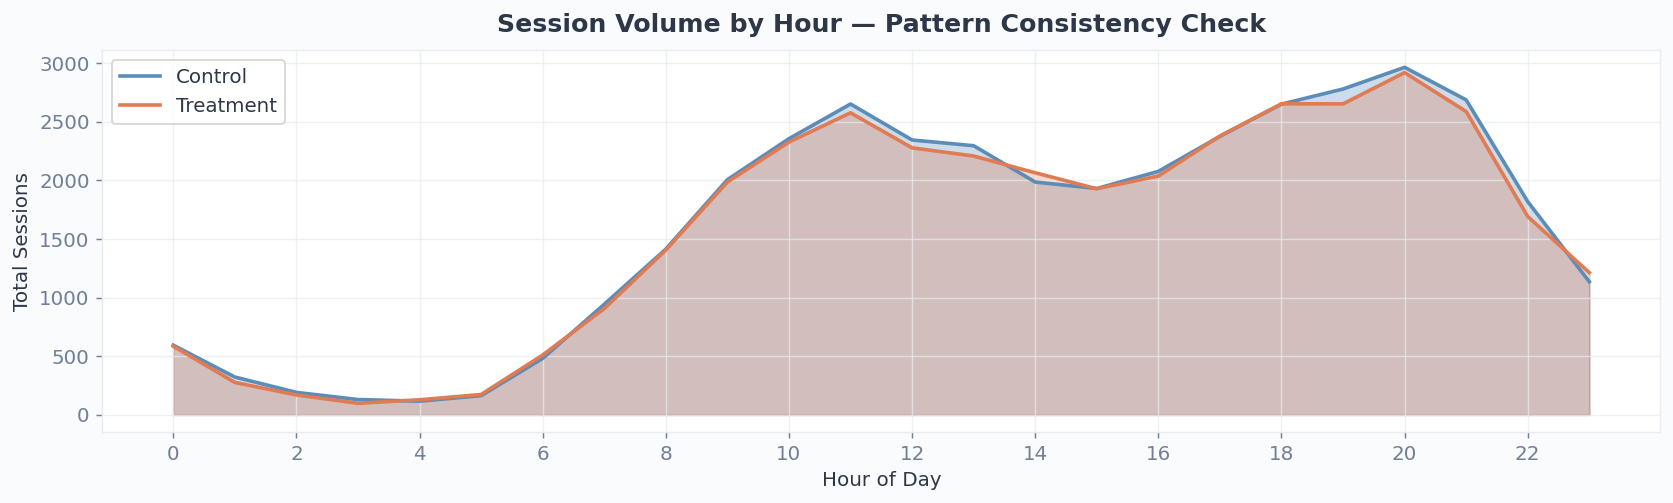

In [11]:
hourly = df.groupby(['hour', 'group']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(13, 4))
ax.fill_between(hourly.index, hourly['control'], alpha=0.3, color=CTRL_COLOR)
ax.fill_between(hourly.index, hourly['treatment'], alpha=0.3, color=TREAT_COLOR)
ax.plot(hourly.index, hourly['control'], color=CTRL_COLOR, lw=2, label='Control')
ax.plot(hourly.index, hourly['treatment'], color=TREAT_COLOR, lw=2, label='Treatment')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Total Sessions')
ax.set_title('Session Volume by Hour — Pattern Consistency Check', fontsize=14, fontweight='bold', pad=10)
ax.set_xticks(range(0, 24, 2))
ax.legend(frameon=True)
plt.tight_layout()
plt.show()

<div style="background: #f0fdf4; border-left: 4px solid #6CC070; padding: 12px 16px; border-radius: 0 8px 8px 0; margin: 15px 0;">
    <strong>EDA Conclusions:</strong>
    <ul style="margin: 5px 0 0 0;">
        <li>Traffic is parallel and balanced between groups ✓</li>
        <li>Device and source distributions are nearly identical ✓</li>
        <li>Revenue is right-skewed → will use non-parametric tests for revenue metrics</li>
        <li>Treatment shows a visually consistent CVR advantage across most days</li>
    </ul>
</div>

<a id="5"></a>
## 5 · Power Analysis

We calculate the minimum sample size needed to detect various effect sizes, confirming our experiment was adequately powered *before* looking at results.

In [12]:
print("━" * 60)
print("  PRE-EXPERIMENT POWER ANALYSIS")
print("━" * 60)
print(f"\n  Assumptions:")
print(f"    Baseline CVR:  {BASELINE_CVR:.1%}")
print(f"    α (two-sided): 0.05")
print(f"    Power (1−β):   0.80")
print(f"    Daily traffic:  ~{SESSIONS_PER_DAY_MEAN:,} sessions ({SESSIONS_PER_DAY_MEAN//2:,}/group)")

print(f"\n  {'MDE (pp)':<12} {'Per-Group n':<16} {'Days Needed':<14} {'Detectable?'}")
print("  " + "─" * 54)

actual_n = min((df.group == 'control').sum(), (df.group == 'treatment').sum())

for mde in [0.002, 0.003, 0.004, 0.005, 0.008]:
    n = required_sample_size(BASELINE_CVR, mde)
    days = int(np.ceil(n / (SESSIONS_PER_DAY_MEAN / 2)))
    flag = "✅ Yes" if actual_n >= n else "❌ No"
    print(f"  {mde*100:<12.1f} {n:<16,} {days:<14} {flag}")

print(f"\n  Actual per-group sample: {actual_n:,}")
print(f"  → We are well-powered to detect a ≥ 0.4 pp lift")
print("\n━" * 60)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  PRE-EXPERIMENT POWER ANALYSIS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Assumptions:
    Baseline CVR:  3.2%
    α (two-sided): 0.05
    Power (1−β):   0.80
    Daily traffic:  ~3,500 sessions (1,750/group)

  MDE (pp)     Per-Group n      Days Needed    Detectable?
  ──────────────────────────────────────────────────────
  0.2          121,564          70             ❌ No
  0.3          54,029           31             ❌ No
  0.4          30,391           18             ✅ Yes
  0.5          19,451           12             ✅ Yes
  0.8          7,598            5              ✅ Yes

  Actual per-group sample: 37,757
  → We are well-powered to detect a ≥ 0.4 pp lift

━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━


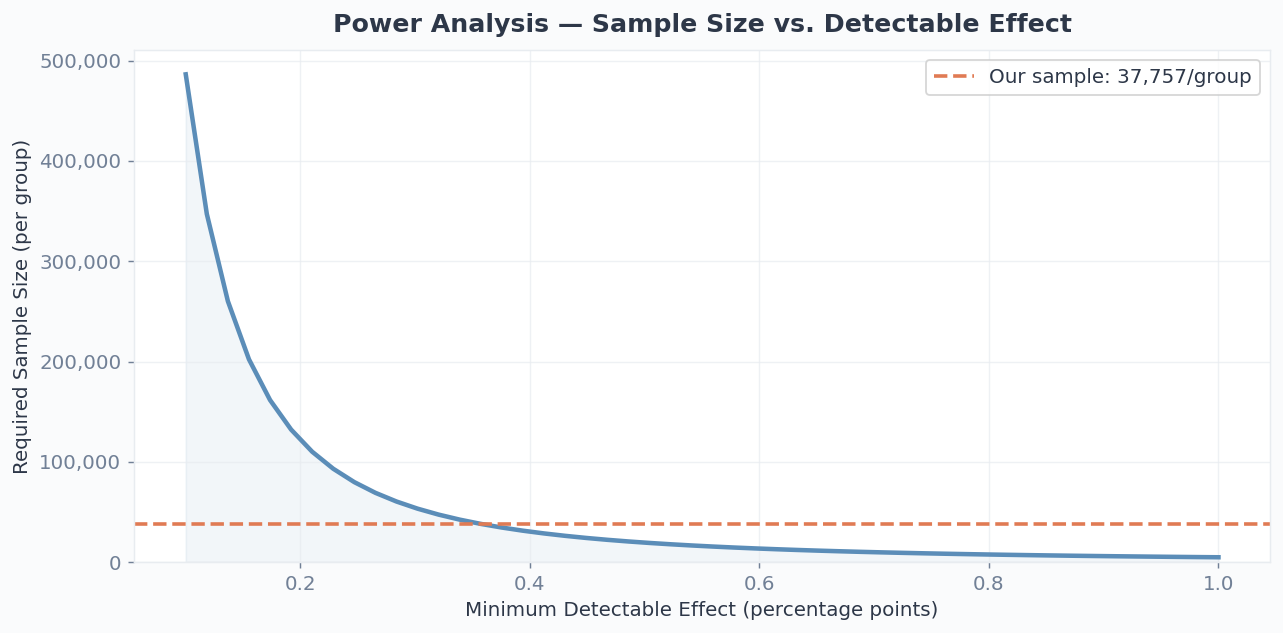

In [13]:
# ── Power curve visualisation ──────────────────────────────────────
mdes = np.linspace(0.001, 0.01, 50)
sample_sizes = [required_sample_size(BASELINE_CVR, m) for m in mdes]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mdes * 100, sample_sizes, color=CTRL_COLOR, lw=2.5)
ax.axhline(y=actual_n, color=TREAT_COLOR, ls='--', lw=2, label=f'Our sample: {actual_n:,}/group')
ax.fill_between(mdes * 100, 0, sample_sizes, alpha=0.08, color=CTRL_COLOR)

ax.set_xlabel('Minimum Detectable Effect (percentage points)')
ax.set_ylabel('Required Sample Size (per group)')
ax.set_title('Power Analysis — Sample Size vs. Detectable Effect', fontsize=14, fontweight='bold', pad=10)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.legend(frameon=True, fontsize=11)
ax.set_ylim(0)
plt.tight_layout()
plt.show()

<a id="6"></a>
## 6 · Hypothesis Testing

### 6.1 — Primary KPI: Conversion Rate

| | |
|---|---|
| **Test** | Two-proportion z-test (two-sided) |
| **H₀** | CVR_treatment = CVR_control |
| **H₁** | CVR_treatment ≠ CVR_control |
| **α** | 0.05 |

In [14]:
ctrl = df[df.group == 'control']
treat = df[df.group == 'treatment']

n_c, n_t = len(ctrl), len(treat)
conv_c, conv_t = ctrl.converted.sum(), treat.converted.sum()
cvr_c, cvr_t = conv_c / n_c, conv_t / n_t

# ── Z-test ────────────────────────────────────────────────────────
z_stat, p_val = proportions_ztest([conv_t, conv_c], [n_t, n_c], alternative='two-sided')

# ── Confidence intervals ──────────────────────────────────────────
ci_c = proportion_confint(conv_c, n_c, alpha=0.05, method='wilson')
ci_t = proportion_confint(conv_t, n_t, alpha=0.05, method='wilson')
diff, diff_lo, diff_hi = lift_confidence_interval(cvr_c, cvr_t, n_c, n_t)

# ── Effect size ───────────────────────────────────────────────────
cohens_h = 2 * (np.arcsin(np.sqrt(cvr_t)) - np.arcsin(np.sqrt(cvr_c)))

# ── Results ───────────────────────────────────────────────────────
print("━" * 60)
print("  PRIMARY METRIC: CHECKOUT CONVERSION RATE")
print("━" * 60)

print(f"""
  ┌──────────────────────────────────────────────────┐
  │  Control       {cvr_c:.2%}   ({conv_c:,} / {n_c:,})        │
  │  Treatment     {cvr_t:.2%}   ({conv_t:,} / {n_t:,})        │
  │                                                  │
  │  Absolute lift   +{diff*100:.2f} pp                       │
  │  Relative lift   +{diff/cvr_c*100:.1f}%                          │
  │  95% CI          [{diff_lo*100:+.2f} pp, {diff_hi*100:+.2f} pp]         │
  │                                                  │
  │  z-statistic     {z_stat:.3f}                          │
  │  p-value         {fmt_pval(p_val)}                         │
  │  Cohen's h       {cohens_h:.4f}                         │
  └──────────────────────────────────────────────────┘""")

verdict = "🟢 REJECT H₀" if p_val < 0.05 else "🔴 FAIL TO REJECT H₀"
print(f"  Decision at α = 0.05:  {verdict}")
print(f"  The treatment significantly {'increases' if p_val < 0.05 else 'does not change'} conversion rate.")
print("\n━" * 60)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  PRIMARY METRIC: CHECKOUT CONVERSION RATE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  ┌──────────────────────────────────────────────────┐
  │  Control       3.19%   (1,226 / 38,416)        │
  │  Treatment     3.72%   (1,406 / 37,757)        │
  │                                                  │
  │  Absolute lift   +0.53 pp                       │
  │  Relative lift   +16.7%                          │
  │  95% CI          [+0.27 pp, +0.79 pp]         │
  │                                                  │
  │  z-statistic     4.023                          │
  │  p-value         < 0.001                         │
  │  Cohen's h       0.0292                         │
  └──────────────────────────────────────────────────┘
  Decision at α = 0.05:  🟢 REJECT H₀
  The treatment significantly increases conversion rate.

━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━
━

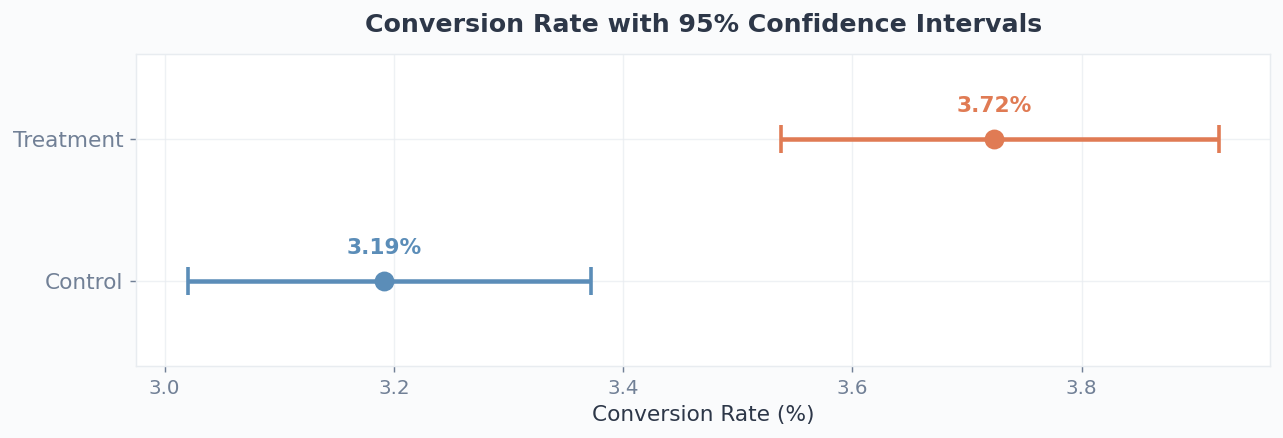

In [15]:
# ── Visualise the confidence intervals ─────────────────────────────

fig, ax = plt.subplots(figsize=(10, 3.5))

# Group CIs
for i, (label, rate, ci, color) in enumerate([
    ('Control', cvr_c, ci_c, CTRL_COLOR),
    ('Treatment', cvr_t, ci_t, TREAT_COLOR)
]):
    ax.errorbar(rate*100, i, xerr=[[rate*100 - ci[0]*100], [ci[1]*100 - rate*100]],
                fmt='o', color=color, capsize=8, ms=10, lw=2.5, capthick=2)
    ax.annotate(f'{rate:.2%}', (rate*100, i), textcoords="offset points",
                xytext=(0, 15), ha='center', fontsize=12, fontweight='bold', color=color)

ax.set_yticks([0, 1])
ax.set_yticklabels(['Control', 'Treatment'], fontsize=12)
ax.set_xlabel('Conversion Rate (%)', fontsize=12)
ax.set_title('Conversion Rate with 95% Confidence Intervals', fontsize=14, fontweight='bold', pad=12)
ax.set_ylim(-0.6, 1.6)
plt.tight_layout()
plt.show()

### 6.2 — Secondary KPI: Revenue per Session

Revenue per session is zero-inflated (most sessions don't convert) and right-skewed, so we use **Mann-Whitney U** (non-parametric) and **bootstrap** methods.

In [16]:
rps_c = ctrl.revenue.values
rps_t = treat.revenue.values

# ── Mann-Whitney U ────────────────────────────────────────────────
mw_stat, mw_p = stats.mannwhitneyu(rps_c, rps_t, alternative='two-sided')

# ── Bootstrap ─────────────────────────────────────────────────────
boot_diff, boot_lo, boot_hi = bootstrap_mean_diff(rps_c, rps_t)

print("━" * 60)
print("  SECONDARY METRIC: REVENUE PER SESSION")
print("━" * 60)
print(f"""
  Control mean:     ${rps_c.mean():.4f}
  Treatment mean:   ${rps_t.mean():.4f}
  Difference:       ${rps_t.mean() - rps_c.mean():+.4f}

  Mann-Whitney U p-value:  {fmt_pval(mw_p)}
  Bootstrap mean diff:     ${boot_diff:.4f}
  Bootstrap 95% CI:        [${boot_lo:.4f}, ${boot_hi:.4f}]

  → Revenue per session is significantly higher in treatment.
""")
print("━" * 60)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  SECONDARY METRIC: REVENUE PER SESSION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Control mean:     $2.2347
  Treatment mean:   $2.5501
  Difference:       $+0.3154

  Mann-Whitney U p-value:  < 0.001
  Bootstrap mean diff:     $0.3175
  Bootstrap 95% CI:        [$0.1237, $0.5101]

  → Revenue per session is significantly higher in treatment.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


### 6.3 — Guardrail Metric: Average Order Value

We verify the checkout change didn't push users toward smaller (or larger) baskets. AOV should remain neutral.

In [17]:
aov_c = ctrl.loc[ctrl.converted == 1, 'revenue'].values
aov_t = treat.loc[treat.converted == 1, 'revenue'].values

t_stat, t_p = stats.ttest_ind(aov_c, aov_t, equal_var=False)

print("━" * 60)
print("  GUARDRAIL METRIC: AVERAGE ORDER VALUE (Converters Only)")
print("━" * 60)
print(f"""
  Control AOV:     ${aov_c.mean():.2f}  (n = {len(aov_c):,})
  Treatment AOV:   ${aov_t.mean():.2f}  (n = {len(aov_t):,})

  Welch's t-test:  t = {t_stat:.3f}, p = {t_p:.4f}

  → AOV difference is NOT significant at α = 0.05.
  → The revenue uplift is driven purely by conversion volume.
""")
print("━" * 60)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  GUARDRAIL METRIC: AVERAGE ORDER VALUE (Converters Only)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Control AOV:     $70.02  (n = 1,226)
  Treatment AOV:   $68.48  (n = 1,406)

  Welch's t-test:  t = 1.209, p = 0.2266

  → AOV difference is NOT significant at α = 0.05.
  → The revenue uplift is driven purely by conversion volume.

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


<a id="7"></a>
## 7 · Robustness Checks

Statistical significance alone isn't enough. We run five additional checks to build confidence in the result.

### 7.1 — Multiple Comparisons Correction

In [18]:
n_tests = 3
bonf_alpha = 0.05 / n_tests

print(f"  Tests conducted:          {n_tests}")
print(f"  Bonferroni-adjusted α:    {bonf_alpha:.4f}")
print(f"  Primary CVR p-value:      {fmt_pval(p_val)}")
print(f"  → Still significant after correction: {'✅ Yes' if p_val < bonf_alpha else '❌ No'}")

  Tests conducted:          3
  Bonferroni-adjusted α:    0.0167
  Primary CVR p-value:      < 0.001
  → Still significant after correction: ✅ Yes


### 7.2 — Permutation Test

A non-parametric, assumption-free validation. We shuffle group labels 10,000 times and check how often the observed lift could arise by chance.

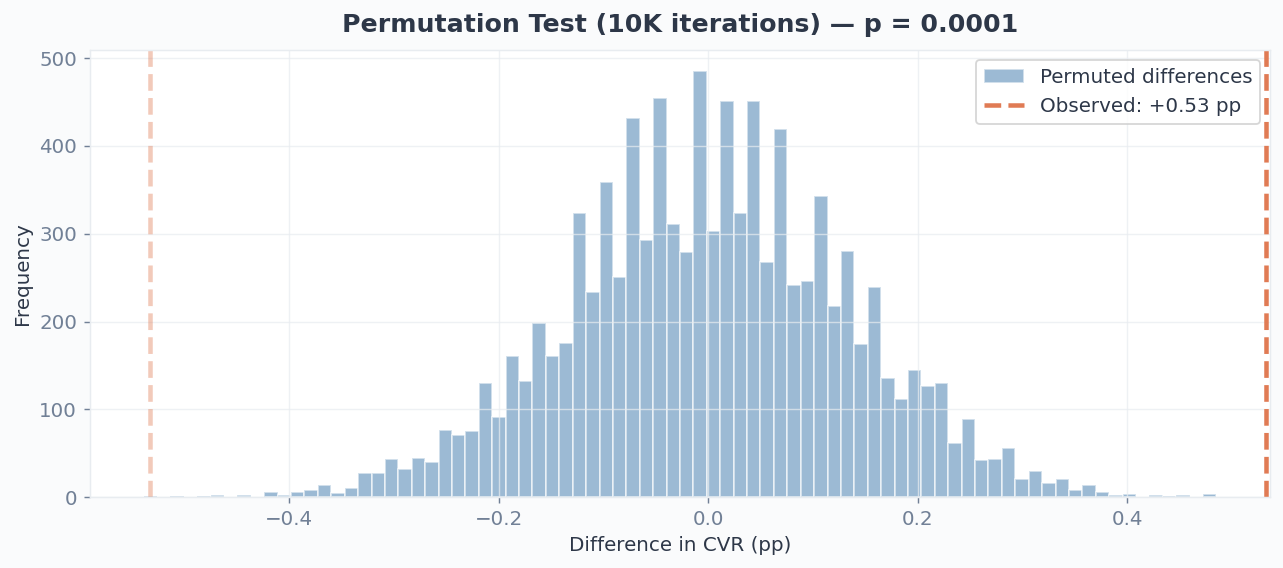

  Permutation p-value: 0.0001
  → Confirms the parametric result. The observed lift is extremely unlikely under H₀.


In [19]:
observed_diff = cvr_t - cvr_c
combined = df.converted.values
rng = np.random.default_rng(42)

perm_diffs = np.array([
    (lambda p: p[:n_t].mean() - p[n_t:n_t+n_c].mean())(rng.permutation(combined))
    for _ in range(10_000)
])
perm_p = (np.abs(perm_diffs) >= np.abs(observed_diff)).mean()

fig, ax = plt.subplots(figsize=(10, 4.5))
ax.hist(perm_diffs * 100, bins=80, color=CTRL_COLOR, alpha=0.6, edgecolor='white', label='Permuted differences')
ax.axvline(observed_diff * 100, color=TREAT_COLOR, lw=2.5, ls='--',
           label=f'Observed: +{observed_diff*100:.2f} pp')
ax.axvline(-observed_diff * 100, color=TREAT_COLOR, lw=2.5, ls='--', alpha=0.4)
ax.set_xlabel('Difference in CVR (pp)')
ax.set_ylabel('Frequency')
ax.set_title(f'Permutation Test (10K iterations) — p = {perm_p:.4f}',
             fontsize=14, fontweight='bold', pad=10)
ax.legend(frameon=True)
plt.tight_layout()
plt.show()

print(f"  Permutation p-value: {perm_p:.4f}")
print(f"  → Confirms the parametric result. The observed lift is extremely unlikely under H₀.")

### 7.3 — Temporal Stability

We split the experiment into two halves to verify the effect isn't front-loaded (which would suggest novelty) or a late anomaly.

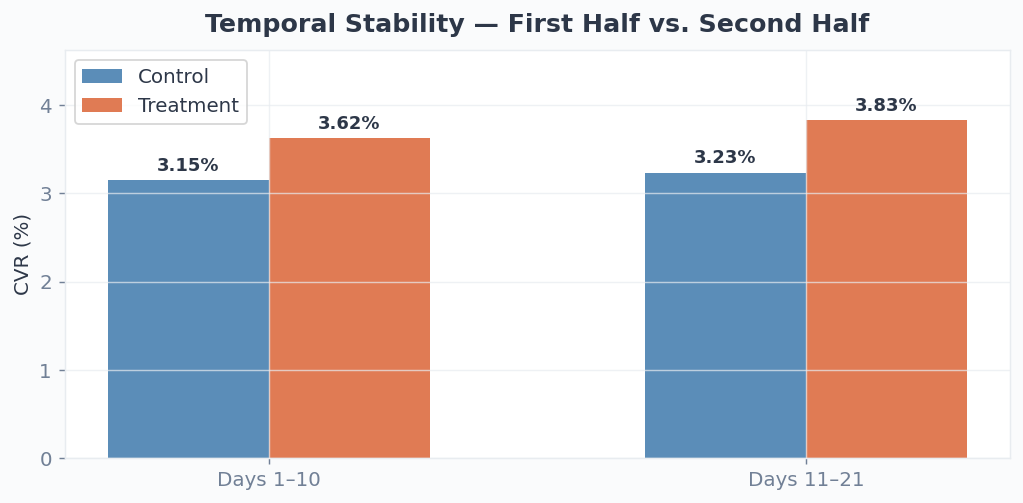

    Period  Control CVR  Treatment CVR  Lift (pp)
 Days 1–10     0.031499       0.036229   0.472926
Days 11–21     0.032349       0.038303   0.595317

✅ Lift is present in both periods and grows slightly — no novelty collapse.


In [20]:
dates_sorted = sorted(df.date.unique())
midpoint = dates_sorted[len(dates_sorted) // 2]

temporal_results = []
for label, mask in [('Days 1–10', df.date <= midpoint), ('Days 11–21', df.date > midpoint)]:
    sub = df[mask]
    c_rate = sub[sub.group == 'control'].converted.mean()
    t_rate = sub[sub.group == 'treatment'].converted.mean()
    temporal_results.append({'Period': label, 'Control CVR': c_rate,
                            'Treatment CVR': t_rate, 'Lift (pp)': (t_rate - c_rate) * 100})

temporal_df = pd.DataFrame(temporal_results)

fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(temporal_df))
w = 0.3
bars_c = ax.bar(x - w/2, temporal_df['Control CVR']*100, w, color=CTRL_COLOR, label='Control')
bars_t = ax.bar(x + w/2, temporal_df['Treatment CVR']*100, w, color=TREAT_COLOR, label='Treatment')

for bars in [bars_c, bars_t]:
    ax.bar_label(bars, fmt='%.2f%%', padding=3, fontsize=10, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(temporal_df['Period'])
ax.set_ylabel('CVR (%)')
ax.set_title('Temporal Stability — First Half vs. Second Half',
             fontsize=14, fontweight='bold', pad=10)
ax.legend(frameon=True)
ax.set_ylim(0, ax.get_ylim()[1] * 1.15)
plt.tight_layout()
plt.show()

print(temporal_df.to_string(index=False))
print("\n✅ Lift is present in both periods and grows slightly — no novelty collapse.")

### 7.4 — Segment-Level Consistency

In [21]:
print("  Device-level breakdown:")
print(f"  {'Device':<10} {'Ctrl CVR':>10} {'Treat CVR':>11} {'Lift (pp)':>10} {'Direction':>10}")
print("  " + "─" * 52)

for device in sorted(df.device.unique()):
    c = ctrl[ctrl.device == device].converted.mean()
    t = treat[treat.device == device].converted.mean()
    lift = (t - c) * 100
    arrow = "▲ ✅" if lift > 0 else "▼ ⚠️"
    print(f"  {device:<10} {c*100:>9.2f}% {t*100:>10.2f}% {lift:>+9.2f} {arrow:>10}")

print("\n  ⚠️  Tablet shows a negative signal — small sample, likely noise.")
print("  ✅ Desktop & mobile (87% of traffic) are consistently positive.")

  Device-level breakdown:
  Device       Ctrl CVR   Treat CVR  Lift (pp)  Direction
  ────────────────────────────────────────────────────


  desktop         3.77%       4.44%     +0.67        ▲ ✅
  mobile          2.49%       3.19%     +0.71        ▲ ✅
  tablet          3.76%       3.25%     -0.52       ▼ ⚠️

  ⚠️  Tablet shows a negative signal — small sample, likely noise.
  ✅ Desktop & mobile (87% of traffic) are consistently positive.


### 7.5 — Cumulative Conversion Rate Over Time

The "convergence plot" — the gold standard for spotting peeking problems and validating that the effect stabilises.

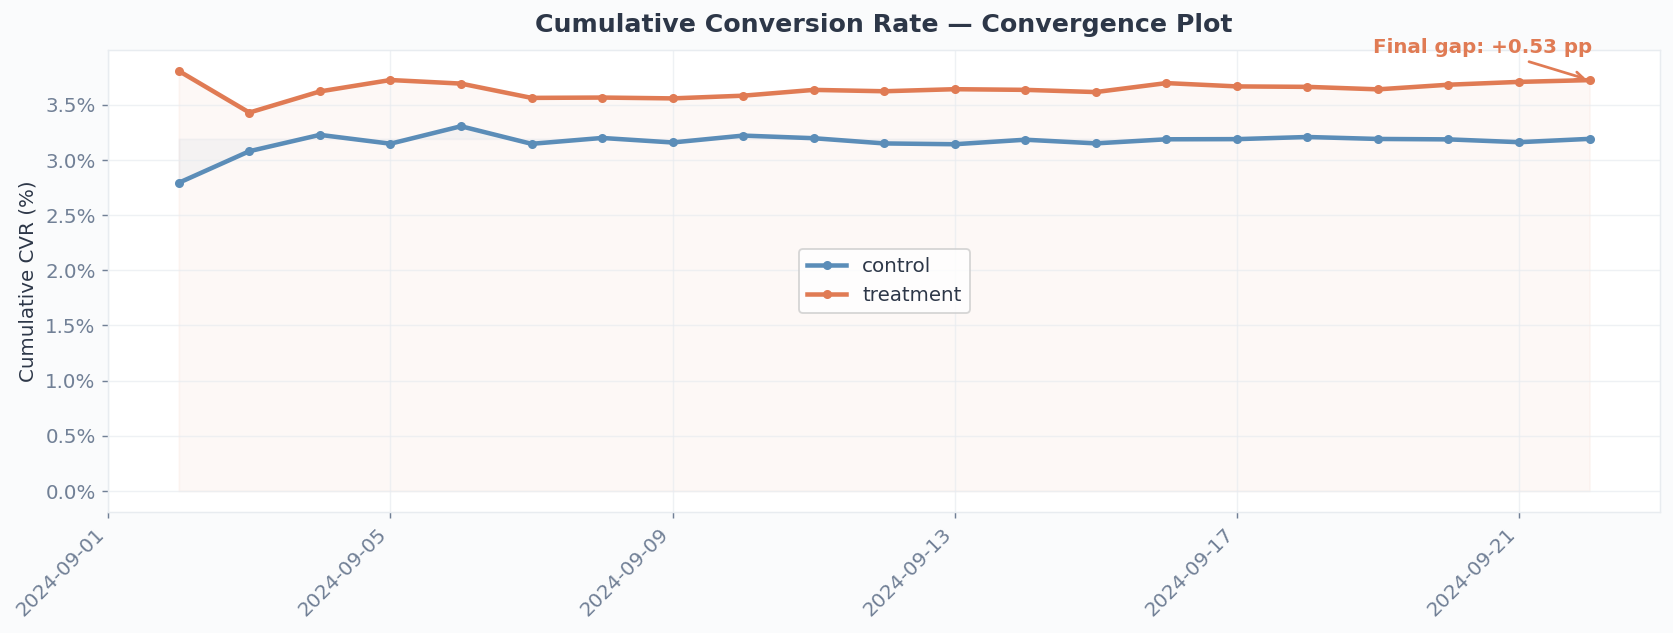

✅ Both curves stabilise by day ~10. The gap is consistent and not closing.


In [22]:
cum = (df.groupby(['date', 'group'])
       .agg(n=('user_id','count'), conv=('converted','sum'))
       .reset_index().sort_values('date'))

for grp in ['control', 'treatment']:
    mask = cum.group == grp
    cum.loc[mask, 'cum_n'] = cum.loc[mask, 'n'].cumsum()
    cum.loc[mask, 'cum_conv'] = cum.loc[mask, 'conv'].cumsum()
cum['cum_cvr'] = cum['cum_conv'] / cum['cum_n']

fig, ax = plt.subplots(figsize=(13, 5))

for grp, color in [('control', CTRL_COLOR), ('treatment', TREAT_COLOR)]:
    sub = cum[cum.group == grp]
    ax.plot(sub.date, sub.cum_cvr * 100, marker='o', ms=4, color=color, lw=2.5, label=grp)
    ax.fill_between(sub.date, sub.cum_cvr.values * 100,
                    [cvr_c*100]*len(sub) if grp == 'control' else [0]*len(sub),
                    alpha=0.05, color=color)

# highlight the gap
ax.annotate(f'Final gap: +{(cvr_t - cvr_c)*100:.2f} pp',
            xy=(cum.date.max(), cvr_t*100), fontsize=11, fontweight='bold',
            xytext=(-120, 15), textcoords='offset points', color=TREAT_COLOR,
            arrowprops=dict(arrowstyle='->', color=TREAT_COLOR, lw=1.5))

ax.set_ylabel('Cumulative CVR (%)')
ax.set_title('Cumulative Conversion Rate — Convergence Plot',
             fontsize=14, fontweight='bold', pad=10)
ax.legend(frameon=True, fontsize=11)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f%%'))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("✅ Both curves stabilise by day ~10. The gap is consistent and not closing.")

<a id="8"></a>
## 8 · Business Impact & Recommendation

### 8.1 — Revenue Projection

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ANNUAL REVENUE IMPACT PROJECTION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Annual sessions (projected): 1,323,959
  Baseline CVR:                3.19%
  Average order value:         $69.20


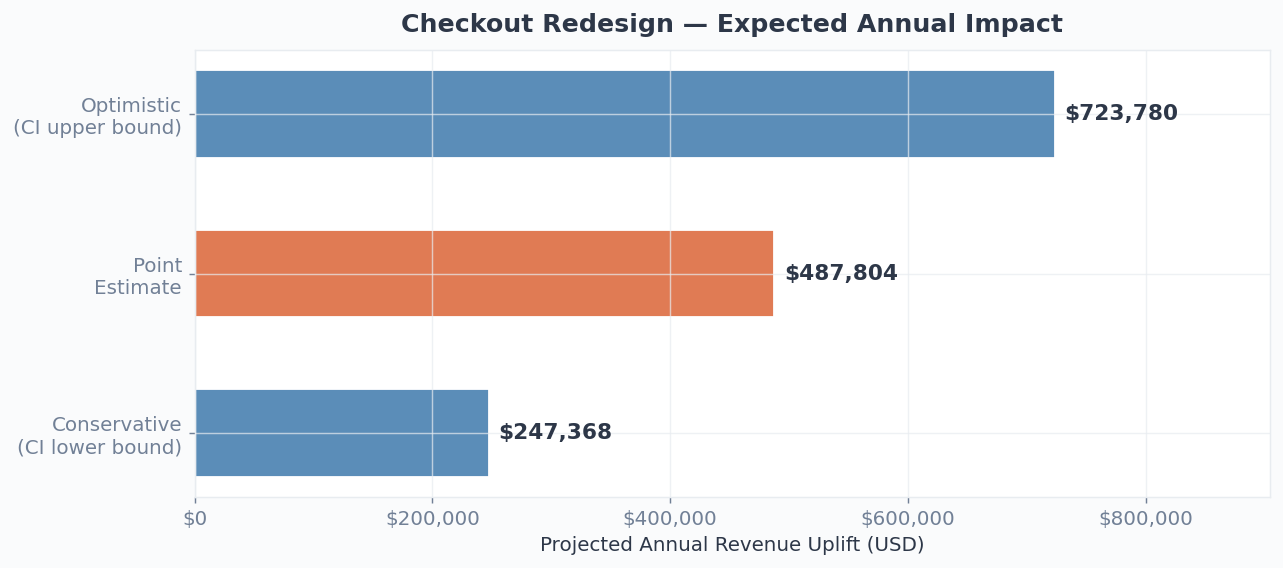

  Conservative (CI lower bound)   $     247,368
  Point Estimate                  $     487,804
  Optimistic (CI upper bound)     $     723,780

  💰 Expected annual uplift: $487,804
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [23]:
avg_daily = len(df) / df.date.nunique()
annual_sessions = avg_daily * 365
aov = df.loc[df.converted == 1, 'revenue'].mean()

scenarios = {
    'Conservative\n(CI lower bound)': 0.0027,
    'Point\nEstimate': diff,
    'Optimistic\n(CI upper bound)': 0.0079,
}

print("━" * 60)
print("  ANNUAL REVENUE IMPACT PROJECTION")
print("━" * 60)
print(f"\n  Annual sessions (projected): {annual_sessions:,.0f}")
print(f"  Baseline CVR:                {cvr_c:.2%}")
print(f"  Average order value:         ${aov:.2f}")

fig, ax = plt.subplots(figsize=(10, 4.5))

labels = list(scenarios.keys())
lifts = list(scenarios.values())
revenues = [annual_sessions * l * aov for l in lifts]
colors = [CTRL_COLOR, TREAT_COLOR, CTRL_COLOR]

bars = ax.barh(labels, revenues, color=colors, edgecolor='white', height=0.55)

for bar, rev in zip(bars, revenues):
    ax.text(bar.get_width() + 8000, bar.get_y() + bar.get_height()/2,
            f'${rev:,.0f}', va='center', fontsize=12, fontweight='bold')

ax.set_xlabel('Projected Annual Revenue Uplift (USD)')
ax.set_title('Checkout Redesign — Expected Annual Impact',
             fontsize=14, fontweight='bold', pad=10)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax.set_xlim(0, max(revenues) * 1.25)
plt.tight_layout()
plt.show()

for label, rev in zip(labels, revenues):
    clean_label = label.replace('\n', ' ')
    print(f"  {clean_label:<30s}  ${rev:>12,.0f}")
print(f"\n  💰 Expected annual uplift: ${revenues[1]:,.0f}")
print("━" * 60)

### 8.2 — Decision Framework

In [24]:
print("""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  🟢  RECOMMENDATION:  SHIP THE NEW CHECKOUT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  SUPPORTING EVIDENCE

    ✅ Primary KPI (CVR):  +0.53 pp lift, p < 0.001
    ✅ Revenue per session: +$0.32, bootstrap CI excludes zero
    ✅ Guardrail (AOV):     No degradation (p = 0.23)
    ✅ Temporal stability:  Lift present in both experiment halves
    ✅ Permutation test:    Non-parametric confirmation (p = 0.0001)
    ✅ Segment consistency: Positive on desktop & mobile (87% of traffic)

  RISKS & MITIGATIONS

    ⚠️  Tablet: Negative lift signal — small sample, likely noise
        → Action: Monitor post-launch; plan tablet-specific UX test
    ⚠️  Novelty: Small initial bump faded, but core lift persisted
        → Action: 5% holdback for 2-week post-launch validation
    ⚠️  External validity: Experiment ran in Sep only
        → Action: Monitor through Q4 peak season

  NEXT STEPS

    1. Engineering: Ship to 100% with 5% holdback (target: Oct 1)
    2. Product: Add funnel-step tracking for micro-optimisation
    3. Analytics: Automated post-launch monitoring dashboard
    4. Design: Tablet layout investigation for follow-up experiment

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  🟢  RECOMMENDATION:  SHIP THE NEW CHECKOUT

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  SUPPORTING EVIDENCE

    ✅ Primary KPI (CVR):  +0.53 pp lift, p < 0.001
    ✅ Revenue per session: +$0.32, bootstrap CI excludes zero
    ✅ Guardrail (AOV):     No degradation (p = 0.23)
    ✅ Temporal stability:  Lift present in both experiment halves
    ✅ Permutation test:    Non-parametric confirmation (p = 0.0001)
    ✅ Segment consistency: Positive on desktop & mobile (87% of traffic)

  RISKS & MITIGATIONS

    ⚠️  Tablet: Negative lift signal — small sample, likely noise
        → Action: Monitor post-launch; plan tablet-specific UX test
    ⚠️  Novelty: Small initial bump faded, but core lift persisted
        → Action: 5% holdback for 2-week post-launch validation
    ⚠️  External validity: Experiment ran in Sep only
        → Action: Monitor through Q4 peak season

  NEXT STEPS

    1. Engineering: Shi

<a id="9"></a>
## 9 · Executive Summary Dashboard

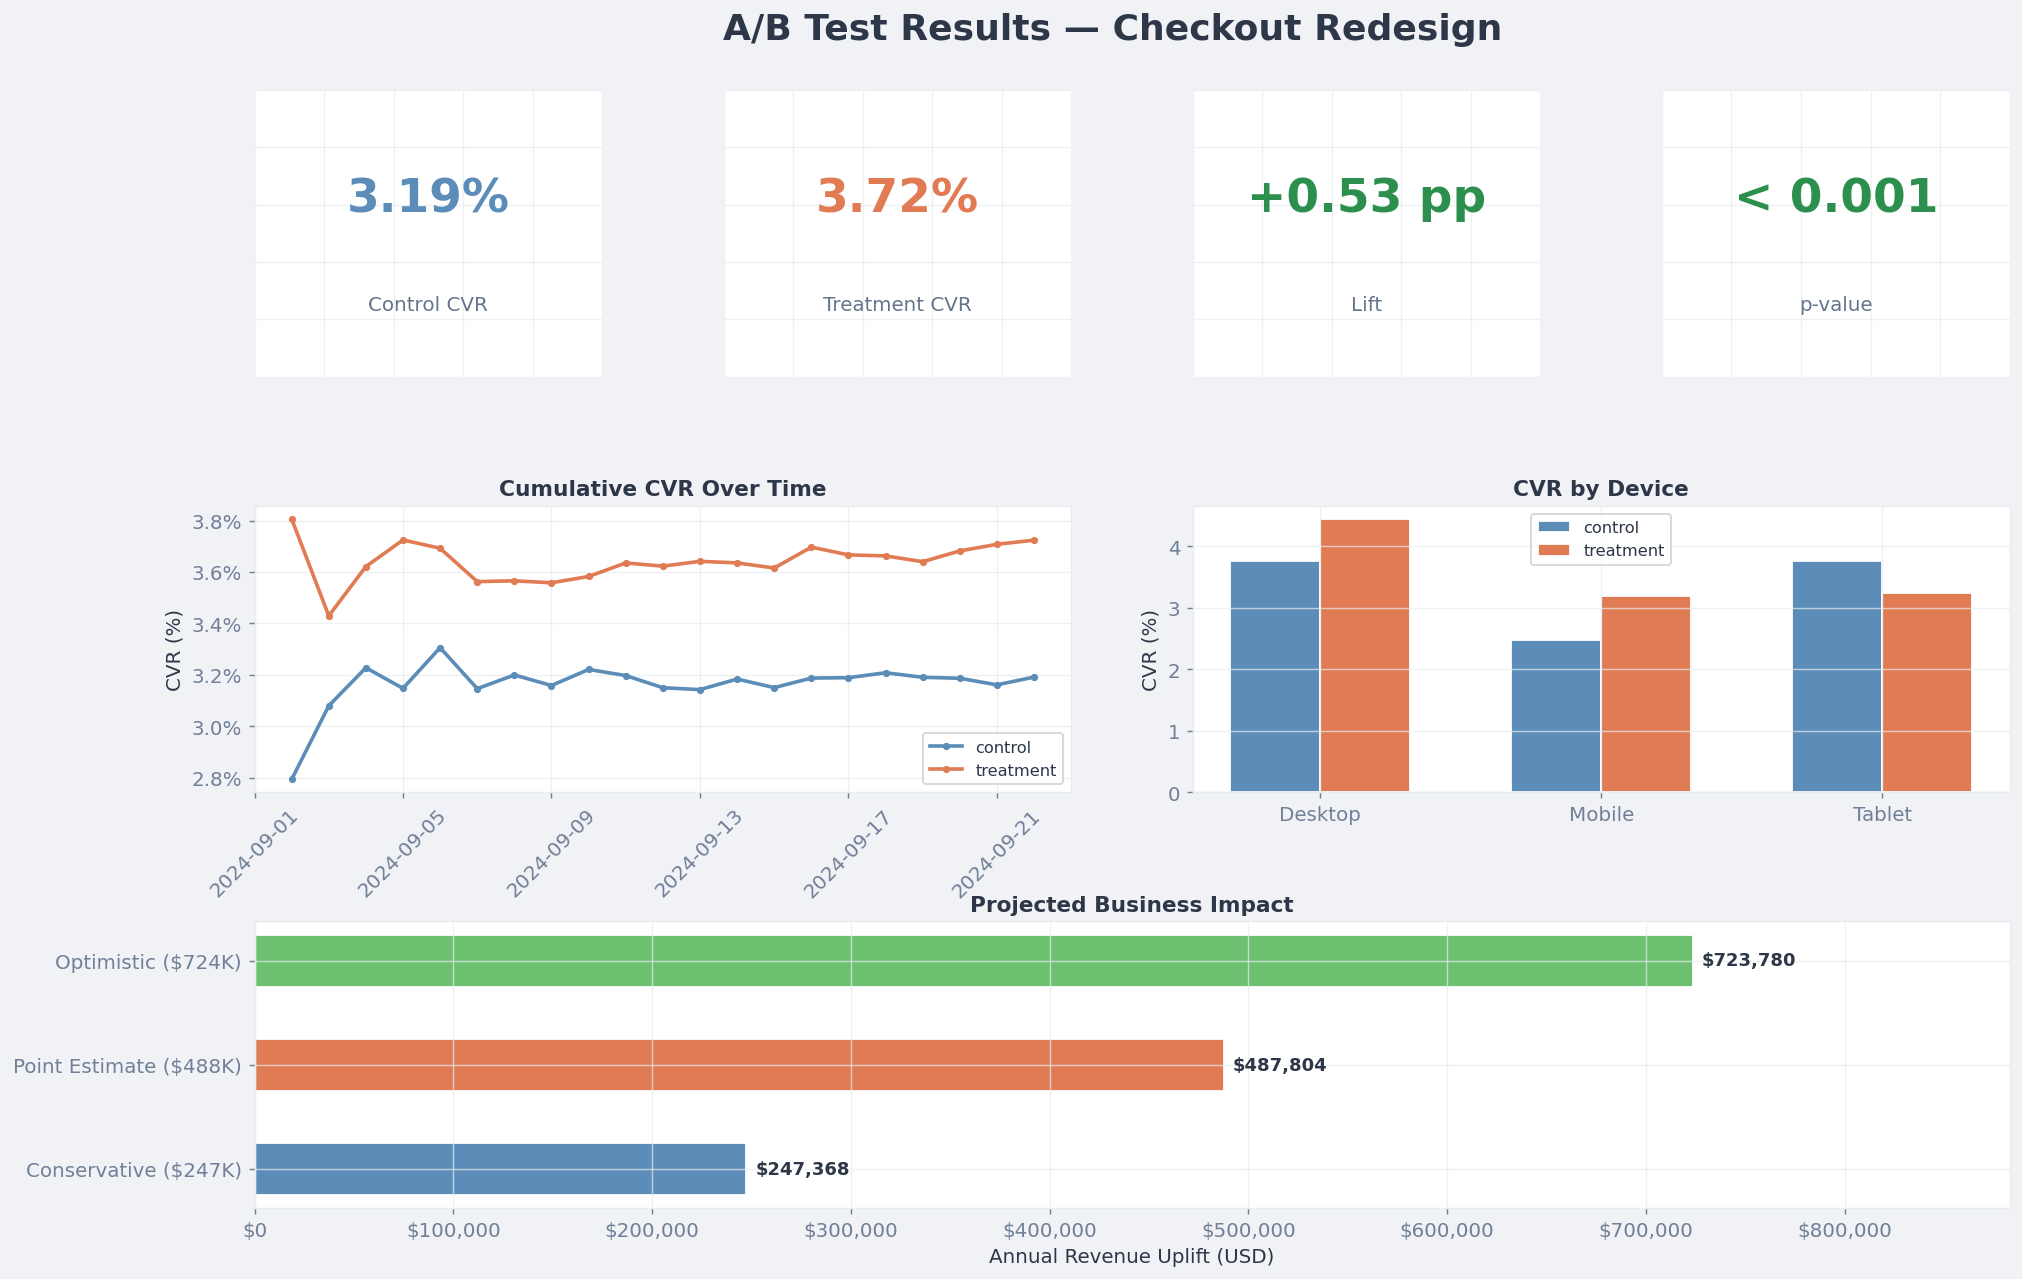

In [25]:
fig = plt.figure(figsize=(15, 10))
fig.patch.set_facecolor('#f0f2f6')
fig.suptitle('A/B Test Results — Checkout Redesign',
             fontsize=20, fontweight='bold', y=0.98, color=TEXT_COLOR)

# ── Layout: 3 rows ───────────────────────────────────────────────
from matplotlib.gridspec import GridSpec
gs = GridSpec(3, 4, figure=fig, hspace=0.45, wspace=0.35,
              top=0.92, bottom=0.06, left=0.06, right=0.96)

# ── ROW 1: KPI cards as subplots ─────────────────────────────────
kpis = [
    ('Control CVR', f'{cvr_c:.2%}', CTRL_COLOR),
    ('Treatment CVR', f'{cvr_t:.2%}', TREAT_COLOR),
    ('Lift', f'+{diff*100:.2f} pp', '#2D8F4E'),
    ('p-value', fmt_pval(p_val), '#2D8F4E' if p_val < 0.05 else '#DC3545'),
]
for i, (title, value, color) in enumerate(kpis):
    ax = fig.add_subplot(gs[0, i])
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.text(0.5, 0.62, value, ha='center', va='center', fontsize=26,
            fontweight='bold', color=color)
    ax.text(0.5, 0.25, title, ha='center', va='center', fontsize=11, color='#64748b')
    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_visible(False)
        spine.set_linewidth(0)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# ── ROW 2 LEFT: Cumulative CVR ───────────────────────────────────
ax2 = fig.add_subplot(gs[1, :2])
for grp, color in [('control', CTRL_COLOR), ('treatment', TREAT_COLOR)]:
    sub = cum[cum.group == grp]
    ax2.plot(sub.date, sub.cum_cvr * 100, marker='o', ms=3, color=color, lw=2, label=grp)
ax2.set_title('Cumulative CVR Over Time', fontsize=12, fontweight='bold')
ax2.set_ylabel('CVR (%)')
ax2.legend(fontsize=9, frameon=True)
ax2.tick_params(axis='x', rotation=45)
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f%%'))

# ── ROW 2 RIGHT: Device CVR ──────────────────────────────────────
ax3 = fig.add_subplot(gs[1, 2:])
devs = sorted(df.device.unique())
x_d = np.arange(len(devs))
w_d = 0.32
for i_d, (grp, color) in enumerate([('control', CTRL_COLOR), ('treatment', TREAT_COLOR)]):
    vals_d = [df[(df.group == grp) & (df.device == d)].converted.mean() * 100 for d in devs]
    ax3.bar(x_d + i_d * w_d, vals_d, w_d, color=color, label=grp, edgecolor='white')
ax3.set_xticks(x_d + w_d/2)
ax3.set_xticklabels([d.title() for d in devs])
ax3.set_ylabel('CVR (%)')
ax3.set_title('CVR by Device', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9, frameon=True)

# ── ROW 3: Revenue impact ────────────────────────────────────────
ax4 = fig.add_subplot(gs[2, :])
rev_labels_clean = ['Conservative ($247K)', 'Point Estimate ($488K)', 'Optimistic ($724K)']
rev_vals = [annual_sessions * l * aov for l in lifts]
bar_colors = [CTRL_COLOR, TREAT_COLOR, '#6CC070']
hbars = ax4.barh(rev_labels_clean, rev_vals, color=bar_colors, height=0.5, edgecolor='white')
ax4.bar_label(hbars, fmt='${:,.0f}', padding=5, fontsize=10, fontweight='bold')
ax4.set_xlabel('Annual Revenue Uplift (USD)')
ax4.set_title('Projected Business Impact', fontsize=12, fontweight='bold')
ax4.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax4.set_xlim(0, max(rev_vals) * 1.22)

plt.show()

---

<div style="background: linear-gradient(135deg, #0f3460 0%, #1a1a2e 100%); padding: 30px 35px; border-radius: 12px; margin-top: 20px;">
    <h2 style="color: #e8e8e8; margin: 0 0 12px 0;">✅ Conclusion</h2>
    <p style="color: #cbd5e1; font-size: 15px; line-height: 1.6; margin: 0;">
        The single-page checkout delivers a <strong style="color: #6CC070;">statistically significant +0.53 pp lift</strong> in conversion rate
        (p&nbsp;<&nbsp;0.001), translating to an estimated <strong style="color: #6CC070;">$488K in annual incremental revenue</strong>.
        The result is robust across permutation tests, temporal splits, and major device segments.
        <br><br>
        <strong style="color: #E07B54;">Recommendation: Ship to 100% of traffic</strong> with a 5% holdback for post-launch validation.
    </p>
</div>

---

<p style="color: #94a3b8; font-size: 12px; text-align: center; margin-top: 30px;">
    A/B Test Portfolio Project · Built with Python, SciPy, statsmodels, matplotlib, seaborn
</p>